# Import libraries

In [1]:
import pandas as pd
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import utils
import config
import re
import os

In [2]:
# set figure details
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Metadata

In [3]:
metadata = pd.read_csv(os.path.join(config.CLEAN_DIR, "metadata.tsv"), sep="\t", index_col=0)
metadata

Patient_No Hospital Date_Collected Time_Collected Timeline_Weeks  \
Sample_ID                                                                      
magic.0001         101       no       12/10/16           1430              0   
magic.0004         101       no       12/15/16            NaN              1   
magic.0006         104      yes       12/15/16           2335              0   
magic.0007         105      yes       12/15/16           2115              0   
magic.0008         105      yes       12/15/16           1525              0   
...                ...      ...            ...            ...            ...   
magic.6595         588      NaN        8/22/21           1702             96   
magic.6597         595      NaN         9/6/21            NaN             96   
magic.6598         585      NaN        8/23/21            725             96   
magic.6599         573      NaN        7/21/21            845             96   
magic.6600         603      NaN        9/12/21           1600             96   

           Abx_regular Abx_anomoly Abx_timeline.prior..during..after. abx_day  \
Sample_ID                                                                       
magic.0001     regular         NaN                                NaN     NaN   
magic.0004     regular         NaN                                NaN     NaN   
magic.0006     regular         NaN                                NaN     NaN   
magic.0007     regular         NaN                                NaN     NaN   
magic.0008     regular         NaN                                NaN     NaN   
...                ...         ...                                ...     ...   
magic.6595     regular         NaN                                NaN     NaN   
magic.6597     regular         NaN                                NaN     NaN   
magic.6598     regular         NaN                                NaN     NaN   
magic.6599     regular         NaN                                NaN     NaN   
magic.6600     regular         NaN                                NaN     NaN   

           Consistency  ... calc_age_mo currentfeed_bf currentfeed_f  \
Sample_ID               ...                                            
magic.0001         NaN  ...        0.07            1.0           0.0   
magic.0004         NaN  ...        0.23            1.0           0.0   
magic.0006         NaN  ...        0.03            1.0           1.0   
magic.0007         NaN  ...        0.03            1.0           1.0   
magic.0008         NaN  ...        0.03            1.0           1.0   
...                ...  ...         ...            ...           ...   
magic.6595         NaN  ...       24.11            NaN           NaN   
magic.6597      formed  ...       24.11            NaN           NaN   
magic.6598      formed  ...       24.34            NaN           NaN   
magic.6599        soft  ...       24.08            NaN           NaN   
magic.6600      formed  ...       23.88            NaN           NaN   

           currentfeed_o         Sequencing_Project                Filename  \
Sample_ID                                                                     
magic.0001    magic.0001        Knights_Project_046   magic.0001.S22.001.fa   
magic.0004    magic.0004        Knights_Project_046   magic.0004.S34.001.fa   
magic.0006    magic.0006  Knights_Project_076_Pool3  magic.0006.S145.001.fa   
magic.0007    magic.0007  Knights_Project_076_Pool3  magic.0007.S155.001.fa   
magic.0008    magic.0008        Knights_Project_055          X8.S125.001.fa   
...                  ...                        ...                     ...   
magic.6595    magic.6595  Knights_Project_077_Pool3  magic.6595.S253.001.fa   
magic.6597    magic.6597  Knights_Project_077_Pool3  magic.6597.S265.001.fa   
magic.6598    magic.6598  Knights_Project_077_Pool3  magic.6598.S277.001.fa   
magic.6599    magic.6599  Knights_Project_077_Pool3  magic.6599.S288.001.fa   
magic.6600    magic.6600  Knight

In [4]:
# genefamilies = pd.read_csv(os.path.join(config.CLEAN_DIR, "humann_genefamilies_clean.tsv"), sep="\t", index_col=0)

# gene_richness = (genefamilies > 0).sum(axis=1)
# metadata["Gene Richness"] = gene_richness

# CAGs = pd.read_csv(os.path.join(config.CLEAN_DIR, "reduced_CAG_profiles_clean.tsv"), sep="\t", index_col=0)
# CAG_richness = (CAGs > 0).sum(axis=1)
# metadata["CAG Richness"] = CAG_richness

# pathways = pd.read_csv(os.path.join(config.CLEAN_DIR, "humann_pathcoverage_clean.tsv"), sep="\t", index_col=0)

# pathway_richness = (pathways > 0.75).sum(axis=1)
# metadata["Pathway Richness"] = pathway_richness

# species = pd.read_csv(os.path.join(config.CLEAN_DIR, "gtdb_species.tsv"), sep="\t", index_col=0)
# species_richness = (species > 0.00001).sum(axis=1)
# metadata["Species Richness"] = species_richness

# metadata

In [5]:
metadata["timepoint"] = metadata["Timeline_Weeks"]

has_time_info = ~metadata["Timeline_Weeks"].isna() & (metadata["Timeline_Weeks"] != "na")
metadata = metadata.loc[has_time_info]
metadata

Patient_No Hospital Date_Collected Time_Collected Timeline_Weeks  \
Sample_ID                                                                      
magic.0001         101       no       12/10/16           1430              0   
magic.0004         101       no       12/15/16            NaN              1   
magic.0006         104      yes       12/15/16           2335              0   
magic.0007         105      yes       12/15/16           2115              0   
magic.0008         105      yes       12/15/16           1525              0   
...                ...      ...            ...            ...            ...   
magic.6595         588      NaN        8/22/21           1702             96   
magic.6597         595      NaN         9/6/21            NaN             96   
magic.6598         585      NaN        8/23/21            725             96   
magic.6599         573      NaN        7/21/21            845             96   
magic.6600         603      NaN        9/12/21           1600             96   

           Abx_regular Abx_anomoly Abx_timeline.prior..during..after. abx_day  \
Sample_ID                                                                       
magic.0001     regular         NaN                                NaN     NaN   
magic.0004     regular         NaN                                NaN     NaN   
magic.0006     regular         NaN                                NaN     NaN   
magic.0007     regular         NaN                                NaN     NaN   
magic.0008     regular         NaN                                NaN     NaN   
...                ...         ...                                ...     ...   
magic.6595     regular         NaN                                NaN     NaN   
magic.6597     regular         NaN                                NaN     NaN   
magic.6598     regular         NaN                                NaN     NaN   
magic.6599     regular         NaN                                NaN     NaN   
magic.6600     regular         NaN                                NaN     NaN   

           Consistency  ... currentfeed_bf currentfeed_f currentfeed_o  \
Sample_ID               ...                                              
magic.0001         NaN  ...            1.0           0.0    magic.0001   
magic.0004         NaN  ...            1.0           0.0    magic.0004   
magic.0006         NaN  ...            1.0           1.0    magic.0006   
magic.0007         NaN  ...            1.0           1.0    magic.0007   
magic.0008         NaN  ...            1.0           1.0    magic.0008   
...                ...  ...            ...           ...           ...   
magic.6595         NaN  ...            NaN           NaN    magic.6595   
magic.6597      formed  ...            NaN           NaN    magic.6597   
magic.6598      formed  ...            NaN           NaN    magic.6598   
magic.6599        soft  ...            NaN           NaN    magic.6599   
magic.6600      formed  ...            NaN           NaN    magic.6600   

                   Sequencing_Project                Filename    Extraction  \
Sample_ID                                                                     
magic.0001        Knights_Project_046   magic.0001.S22.001.fa    MagAttract   
magic.0004        Knights_Project_046   magic.0004.S34.001.fa    MagAttract   
magic.0006  Knights_Project_076_Pool3  magic.0006.S145.001.fa     PowerSoil   
magic.0007  Knights_Project_076_Pool3  magic.0007.S155.001.fa     PowerSoil   
magic.0008        Knights_Project_055          X8.S125.001.fa     PowerSoil   
...                               ...                     ...           ...   
magic.6595  Knights_Project_077_Pool3  magic.6595.S253.001.fa  PowerSoilPro   
magic.6597  Knights_Project_077_Pool3  magic.6597.S265.001.fa  PowerSoilPro   
magic.6598  Knights_Project_077_Pool3  magic.6598.S277.001.fa  PowerSoilPro   
magic.6599  Knights_Project_077_Pool3  magic.6599.S288.001.fa  PowerSoilPro   
magic.

In [6]:
metadata.index = metadata["Patient_No"]
metadata["timepoint_plot"] = [int(time) for time in metadata["timepoint"]]
# metadata["timepoint_plot"] = metadata["timepoint_plot"].apply(lambda x : {0 : 0, 1 : 1, 2 : 2, 3 : 3, 4 : 4, 
#     12: 5, 24 : 6, 36 : 7, 48 : 8, 60 : 9, 72 : 10, 84 : 11, 96 : 12}[x])
metadata

/var/folders/w8/85y9rkfs49x53d7kk_ql70bc0000gn/T/ipykernel_20148/1879103518.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata["timepoint_plot"] = [int(time) for time in metadata["timepoint"]]


Patient_No Hospital Date_Collected Time_Collected Timeline_Weeks  \
Patient_No                                                                     
101                101       no       12/10/16           1430              0   
101                101       no       12/15/16            NaN              1   
104                104      yes       12/15/16           2335              0   
105                105      yes       12/15/16           2115              0   
105                105      yes       12/15/16           1525              0   
...                ...      ...            ...            ...            ...   
588                588      NaN        8/22/21           1702             96   
595                595      NaN         9/6/21            NaN             96   
585                585      NaN        8/23/21            725             96   
573                573      NaN        7/21/21            845             96   
603                603      NaN        9/12/21           1600             96   

           Abx_regular Abx_anomoly Abx_timeline.prior..during..after. abx_day  \
Patient_No                                                                      
101            regular         NaN                                NaN     NaN   
101            regular         NaN                                NaN     NaN   
104            regular         NaN                                NaN     NaN   
105            regular         NaN                                NaN     NaN   
105            regular         NaN                                NaN     NaN   
...                ...         ...                                ...     ...   
588            regular         NaN                                NaN     NaN   
595            regular         NaN                                NaN     NaN   
585            regular         NaN                                NaN     NaN   
573            regular         NaN                                NaN     NaN   
603            regular         NaN                                NaN     NaN   

           Consistency  ... currentfeed_f currentfeed_o  \
Patient_No              ...                               
101                NaN  ...           0.0    magic.0001   
101                NaN  ...           0.0    magic.0004   
104                NaN  ...           1.0    magic.0006   
105                NaN  ...           1.0    magic.0007   
105                NaN  ...           1.0    magic.0008   
...                ...  ...           ...           ...   
588                NaN  ...           NaN    magic.6595   
595             formed  ...           NaN    magic.6597   
585             formed  ...           NaN    magic.6598   
573               soft  ...           NaN    magic.6599   
603             formed  ...           NaN    magic.6600   

                   Sequencing_Project                Filename    Extraction  \
Patient_No                                                                    
101               Knights_Project_046   magic.0001.S22.001.fa    MagAttract   
101               Knights_Project_046   magic.0004.S34.001.fa    MagAttract   
104         Knights_Project_076_Pool3  magic.0006.S145.001.fa     PowerSoil   
105         Knights_Project_076_Pool3  magic.0007.S155.001.fa     PowerSoil   
105               Knights_Project_055          X8.S125.001.fa     PowerSoil   
...                               ...                     ...           ...   
588         Knights_Project_077_Pool3  magic.6595.S253.001.fa  PowerSoilPro   
595         Knights_Project_077_Pool3  magic.6597.S265.001.fa  PowerSoilPro   
585         Knights_Project_077_Pool3  magic.6598.S277.001.fa  PowerSoilPro   
573         Knights_Project_077_Pool3  magic.6599.S288.001.fa  PowerSoilPro   
603         Knights_Project_077_Pool3  magic.6600.S361.001.fa  PowerSoilPro   

              depth  bos_taurus_read_count  unreduced_gene_richness timepoint  \
Patient_No                              

In [7]:
metadata.columns

Index(['Patient_No', 'Hospital', 'Date_Collected', 'Time_Collected',
       'Timeline_Weeks', 'Abx_regular', 'Abx_anomoly',
       'Abx_timeline.prior..during..after.', 'abx_day', 'Consistency', 'Color',
       'Amount', 'dob', 'babysex', 'gestational_age_wk',
       'gestational_age_days', 'weight1', 'sizeforgestationalage', 'icn',
       'icnabx', 'mat_ageatadm', 'gravidity_n', 'parity_n', 'laboronset_type',
       'rom_hr', 'deliverymethod', 'sepsisrisk', 'multip_yn',
       'weight_prepregnancy_2', 'maternalheight', 'gbs_result', 'motherrace',
       'motherethnicity', 'expo_cat1', 'expo_cat2', 'calc_age_mo',
       'currentfeed_bf', 'currentfeed_f', 'currentfeed_o',
       'Sequencing_Project', 'Filename', 'Extraction', 'depth',
       'bos_taurus_read_count', 'unreduced_gene_richness', 'timepoint',
       'timepoint_plot'],
      dtype='object')

In [9]:
metadata["Gene Richness (Full)"] = metadata["unreduced_gene_richness"]

/var/folders/w8/85y9rkfs49x53d7kk_ql70bc0000gn/T/ipykernel_20148/3821599016.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata["Gene Richness (Full)"] = metadata["unreduced_gene_richness"]


In [10]:
timepoints_sorted = np.unique(metadata["Timeline_Weeks"])
timepoints_sorted = sorted(timepoints_sorted, key=lambda x : int(x))

In [11]:
def plot_index(index, variable):
    options = set([r for r in metadata[variable]])
    for option in options:
        print(option)
        fig = plt.figure(figsize=(16, 4), dpi=200)
        ax = plt.gca()
        
        plotted_longitudinal = []

        subjects = np.unique(metadata.index)
        for subject in subjects:
            df = metadata.loc[[subject]].copy()
            df = df[df[variable] == option]
            df = df.sort_values("timepoint_plot")
            df = df.drop_duplicates("Timeline_Weeks")
            plotted_longitudinal.append(df)
            ax.plot(df["timepoint_plot"], df[index], c="gray", zorder=0, alpha=0.2)
        ax.set_xticks([int(t) for t in timepoints_sorted])
        ax.set_xticklabels(timepoints_sorted)
        ax.set_ylabel(index, fontsize=18)
        ax.set_xlabel("Time point (weeks)", fontsize=18)
        
        plotted_df = pd.concat(plotted_longitudinal)

        for i, time in enumerate(timepoints_sorted):
            data = plotted_df[plotted_df["timepoint"] == time][index]
            sc = ax.scatter(np.ones(data.shape[0]) * int(time), data, s=2 if i < 5 else 10)
            c = sc.get_facecolors()[0].tolist()
            width = 2.0 if i < 5 else 2
            widths = 0.75 if i < 5 else 3
            bp = ax.boxplot(data, positions=[int(time)], patch_artist=True, widths=[widths],
                boxprops=dict(facecolor=[0, 0, 0, 0], color=c, linewidth=width),
                capprops=dict(color=c, linewidth=0),
                whiskerprops=dict(color=c, linewidth=width),
                flierprops=dict(color=c, markeredgecolor=c, linewidth=width),
                medianprops=dict(color=c, linewidth=width))

Female
Male


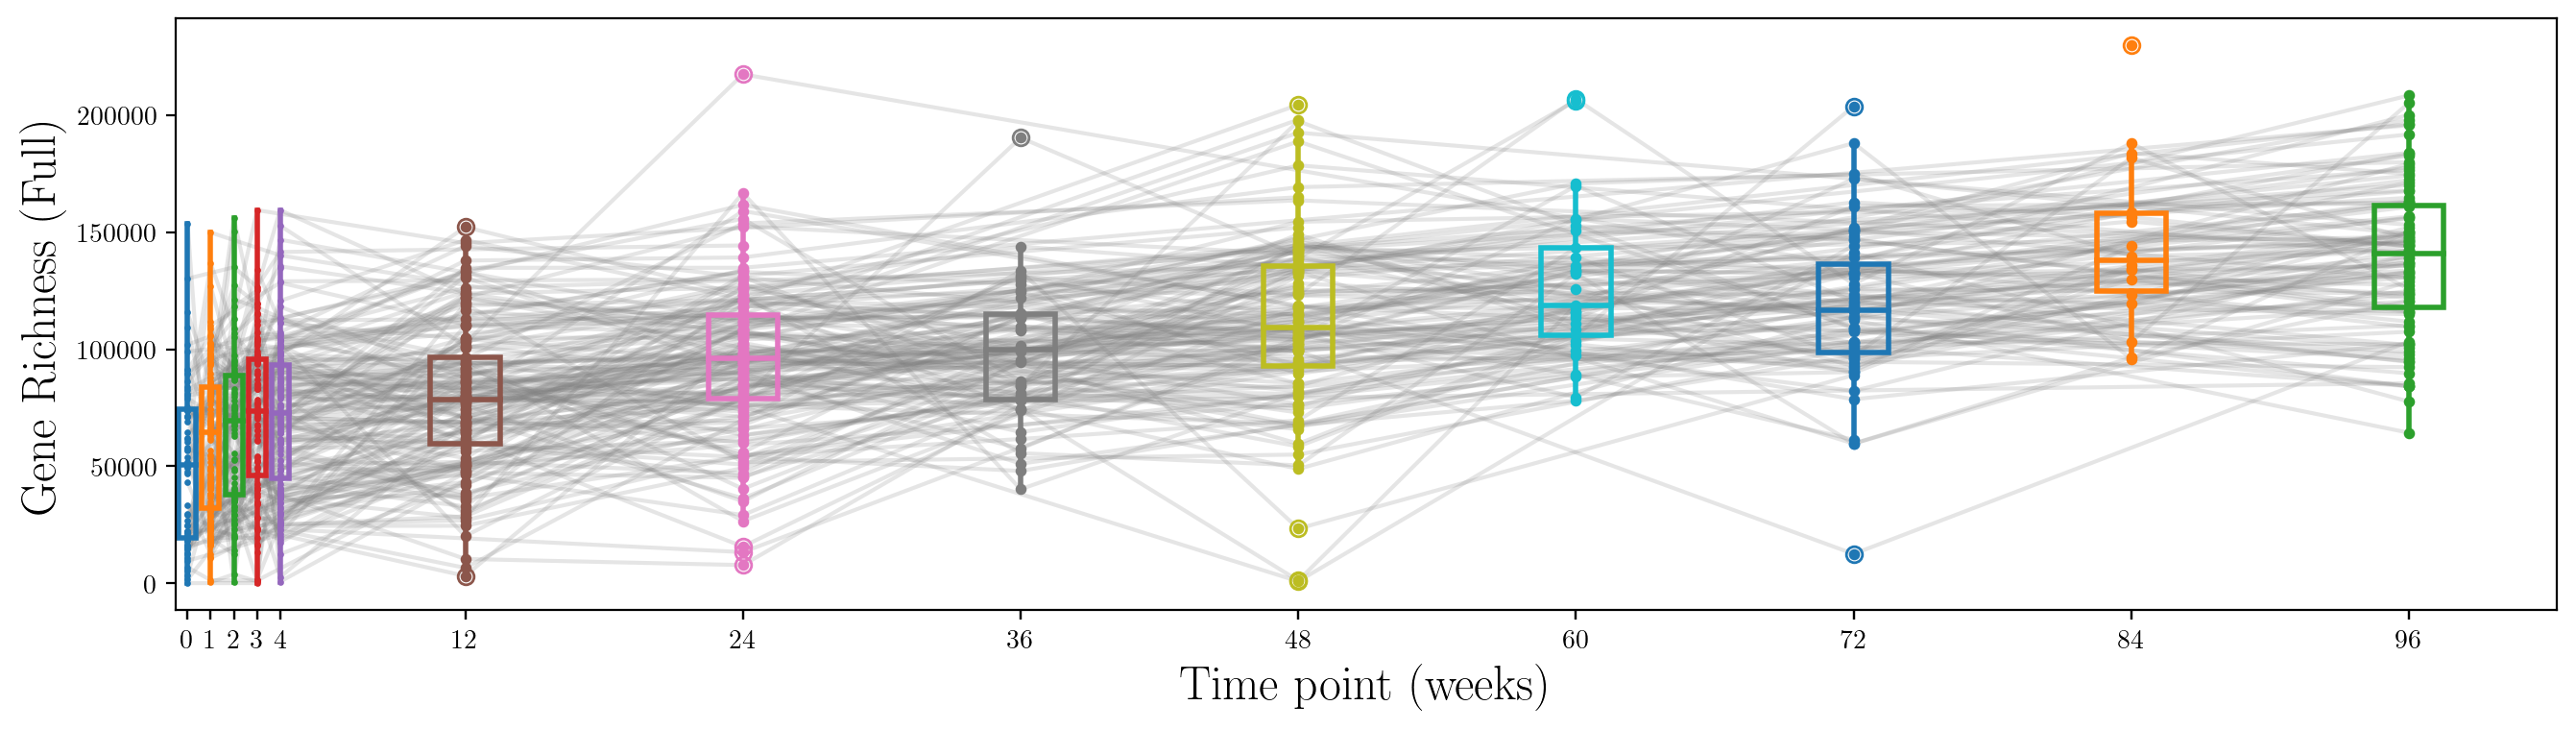

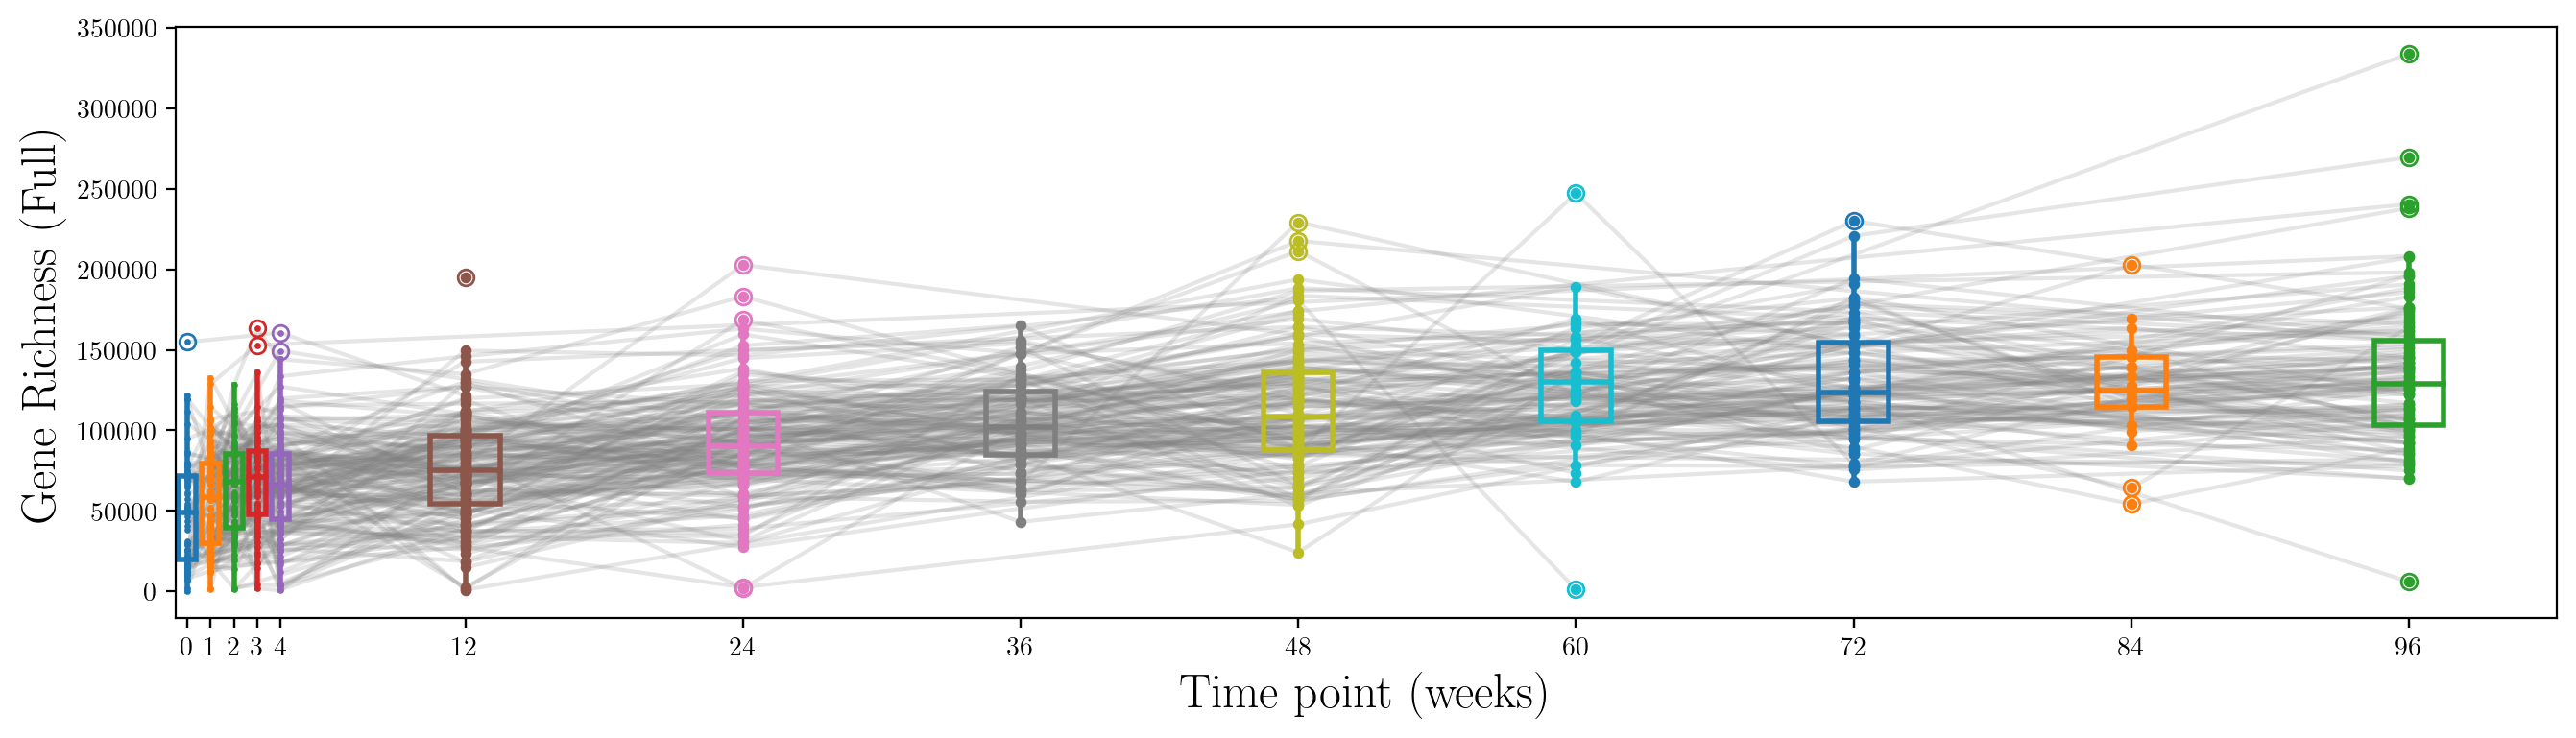

In [12]:
plot_index("Gene Richness (Full)", "babysex")

Yes
No


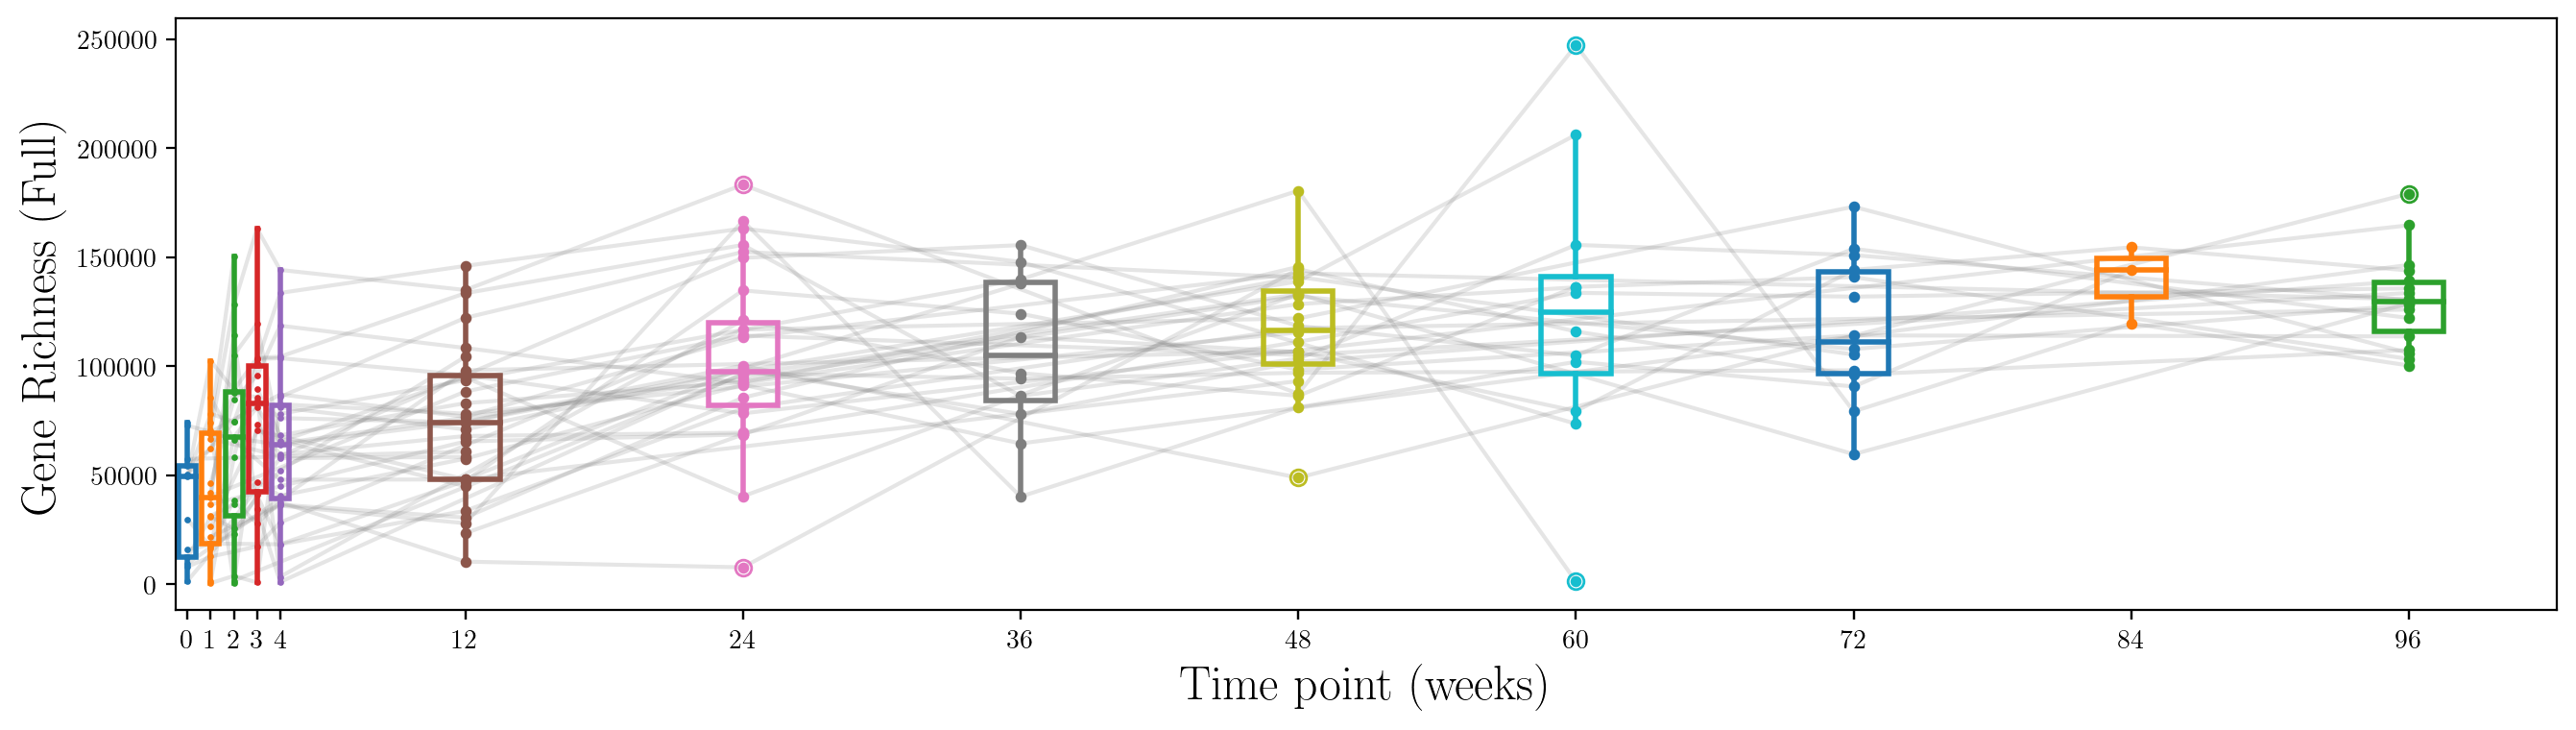

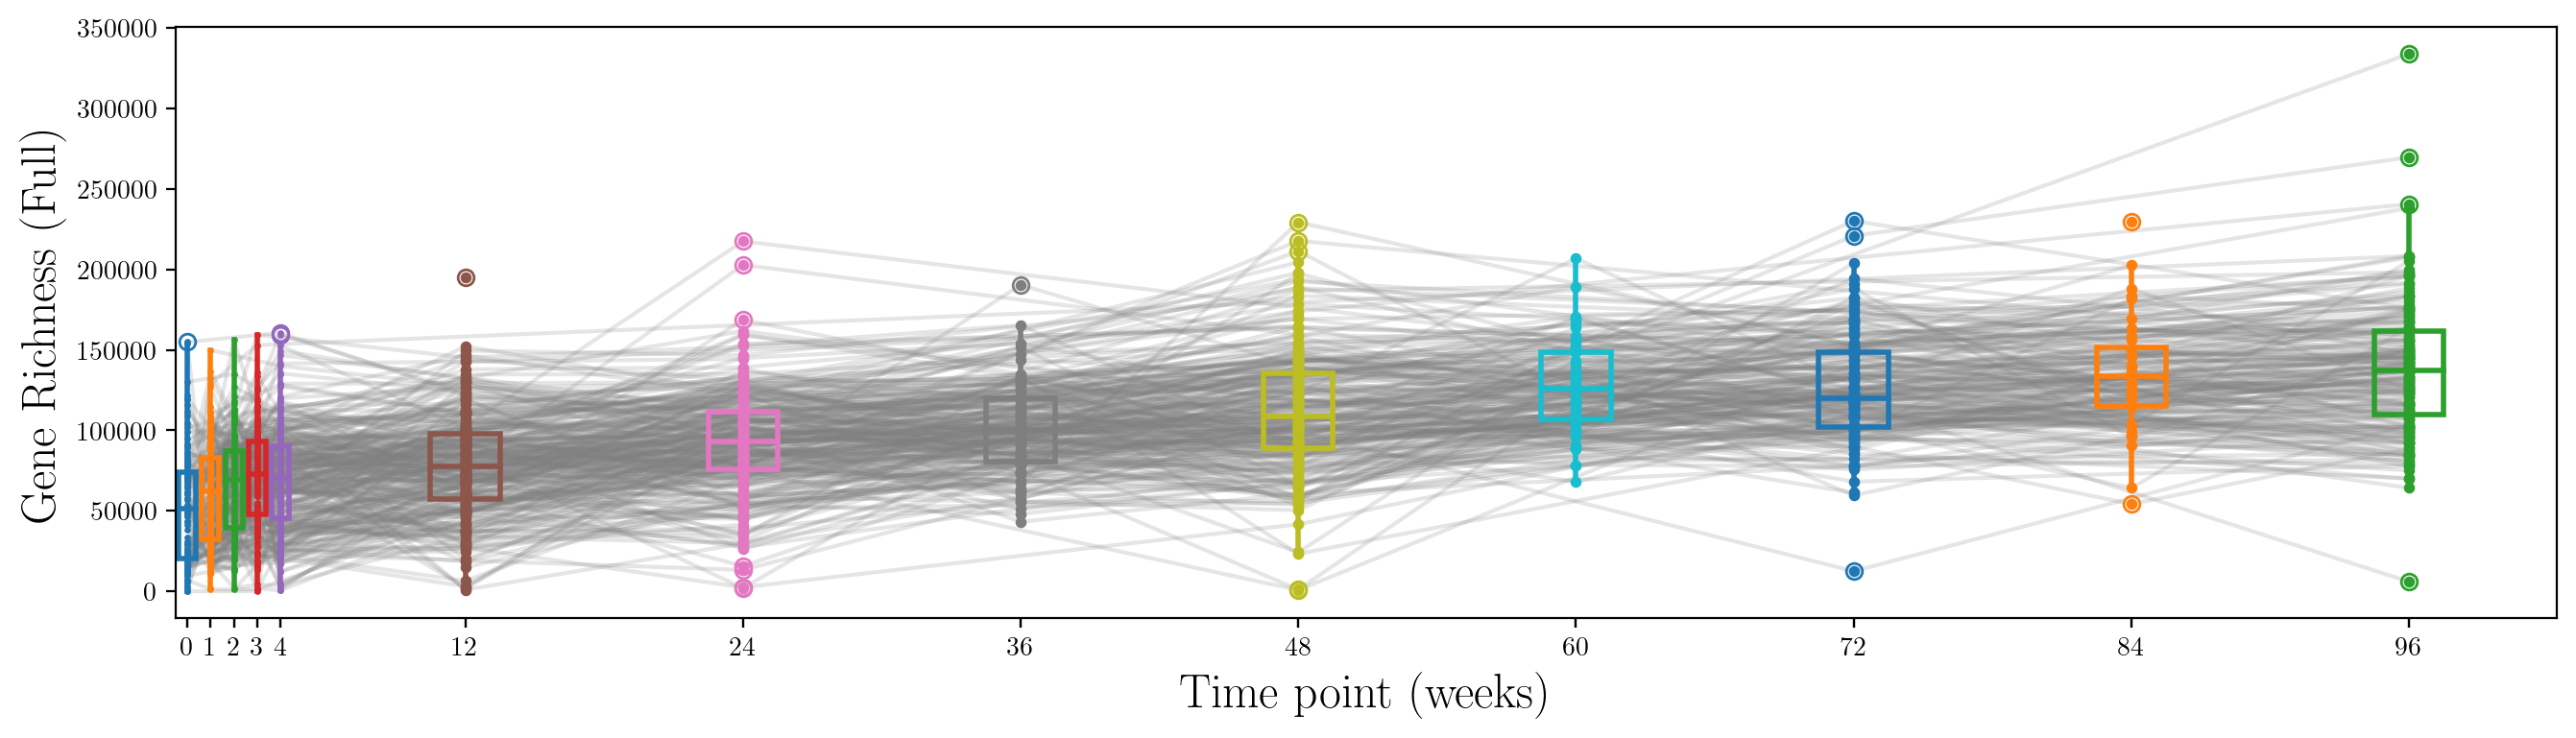

In [13]:
plot_index("Gene Richness (Full)", "icn")

Yes
No


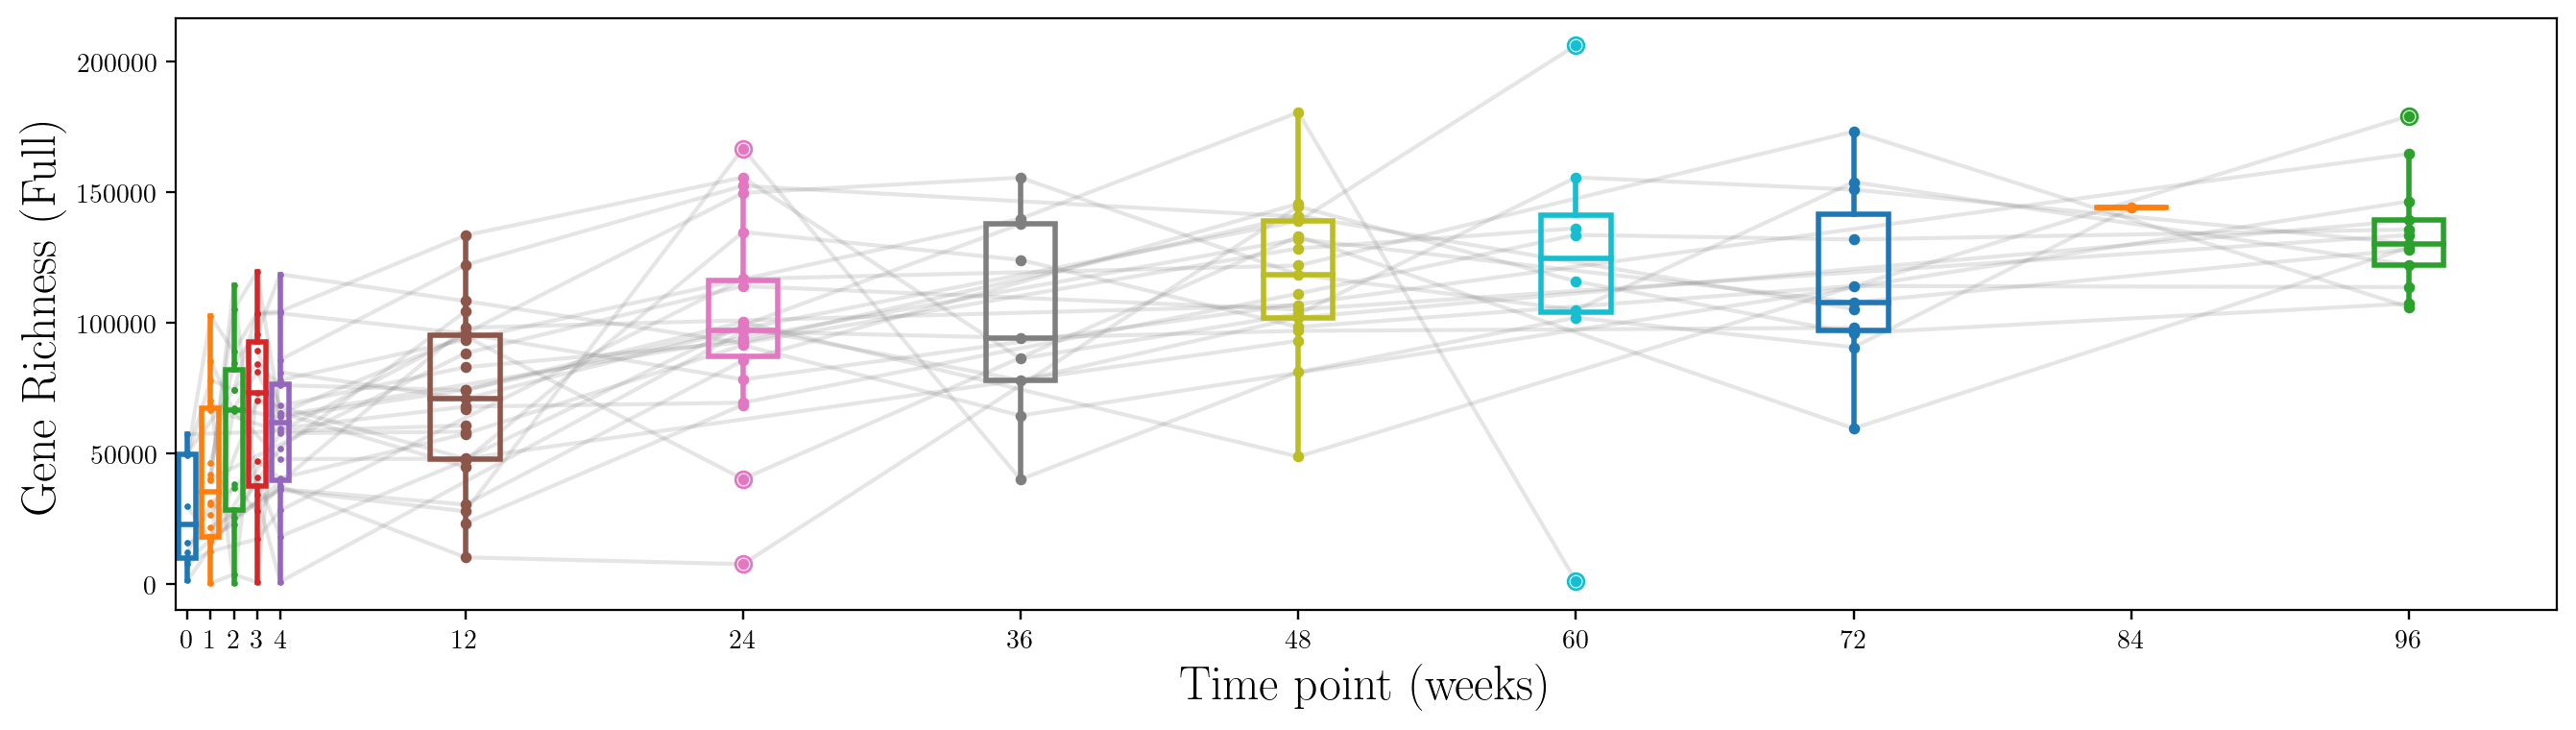

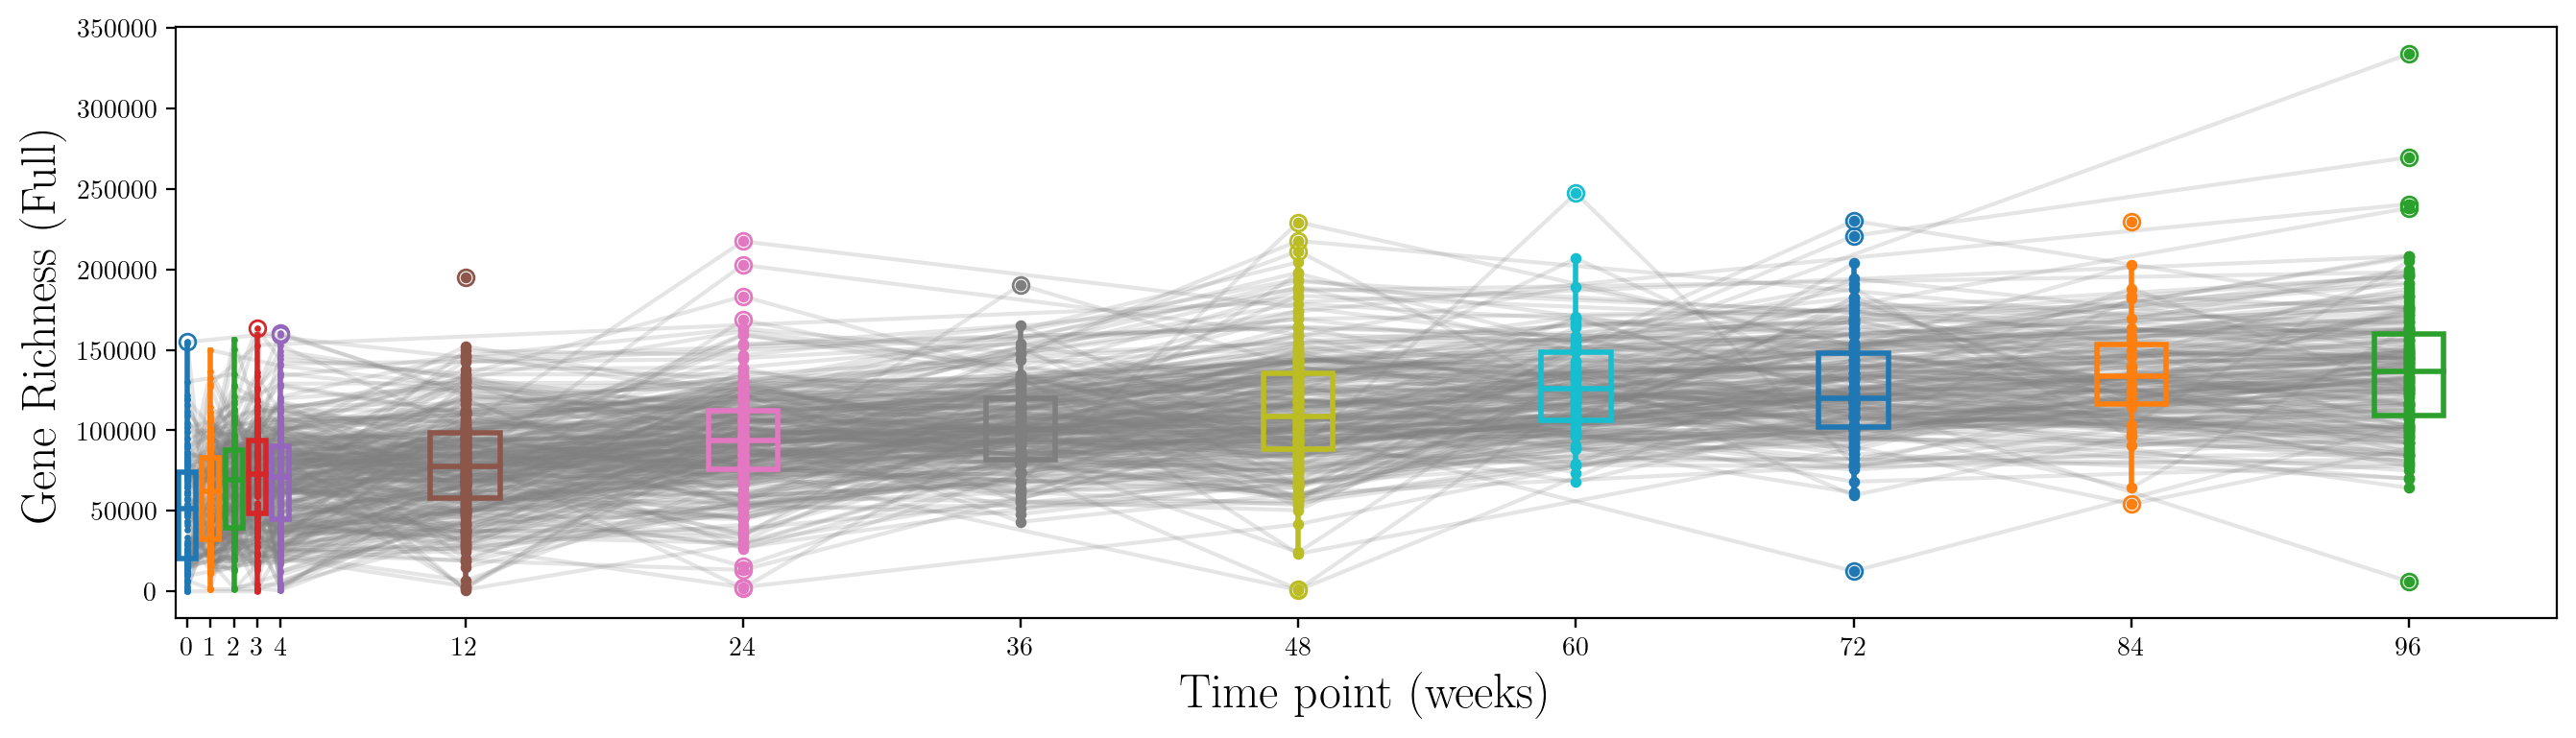

In [14]:
plot_index("Gene Richness (Full)", "icnabx")

Unknown/pending
Positive
Negative
nan


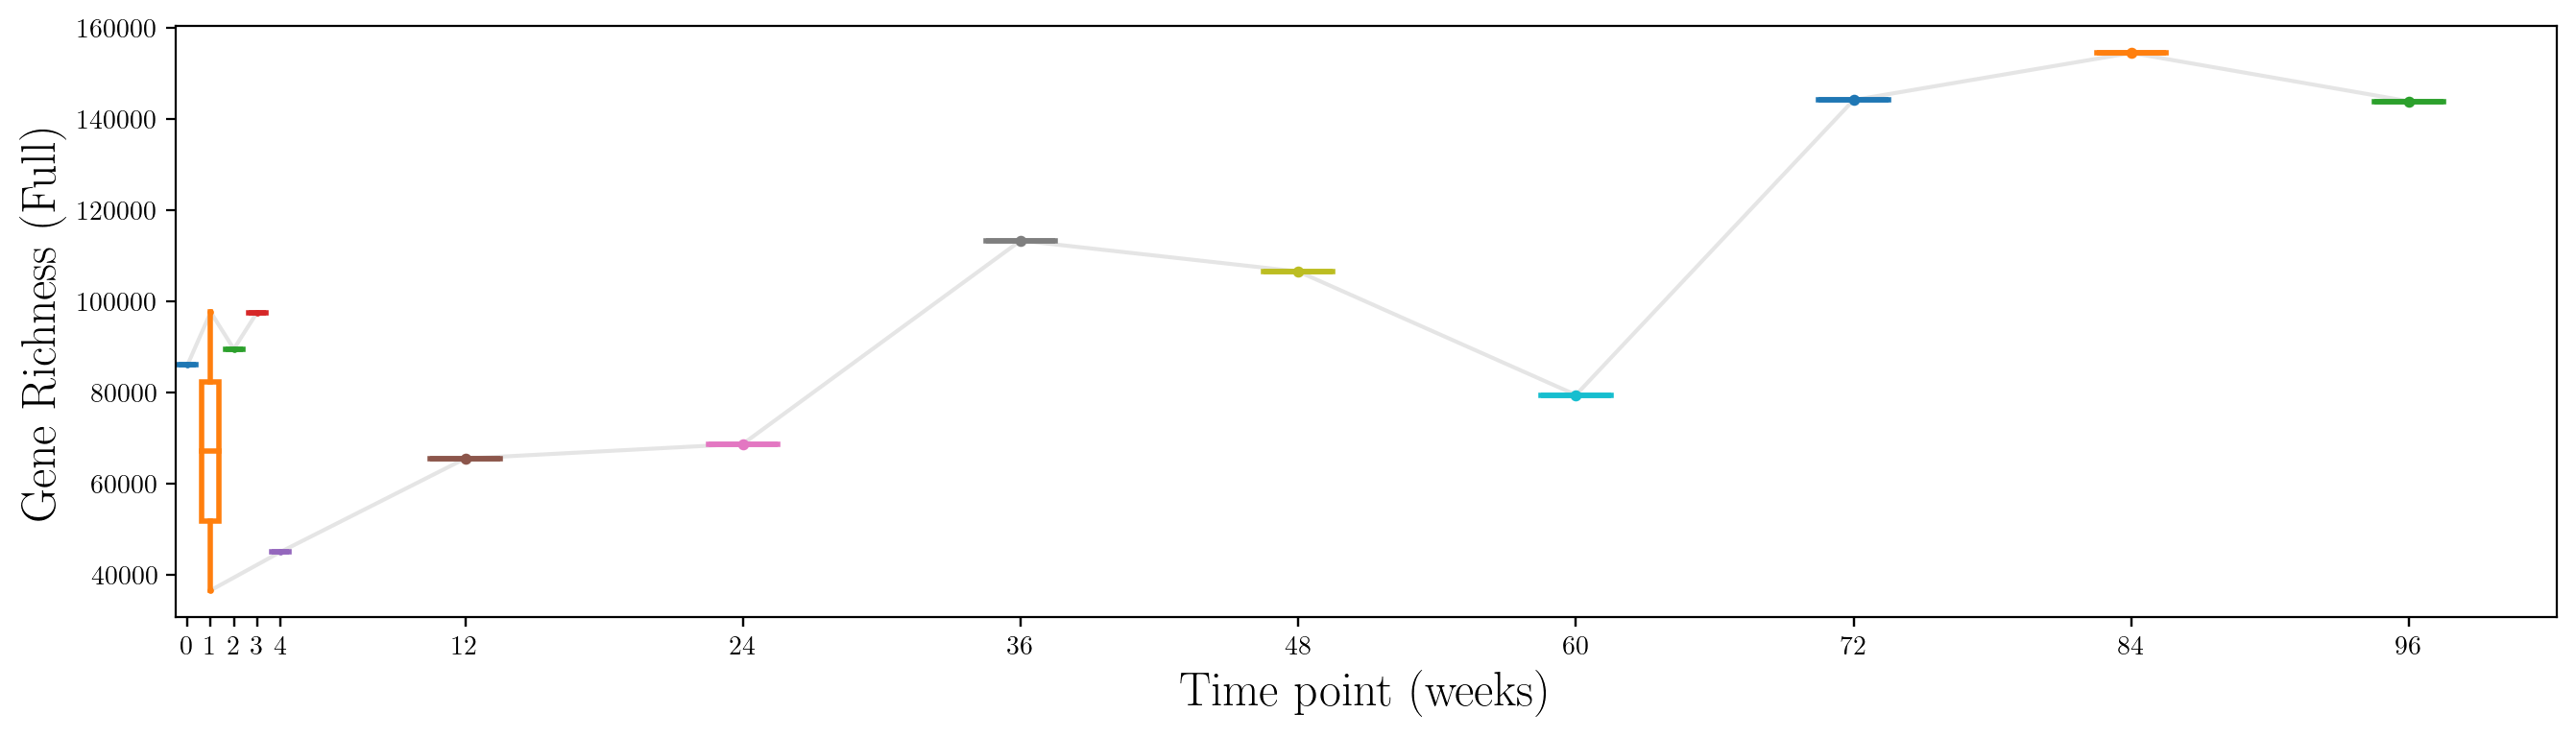

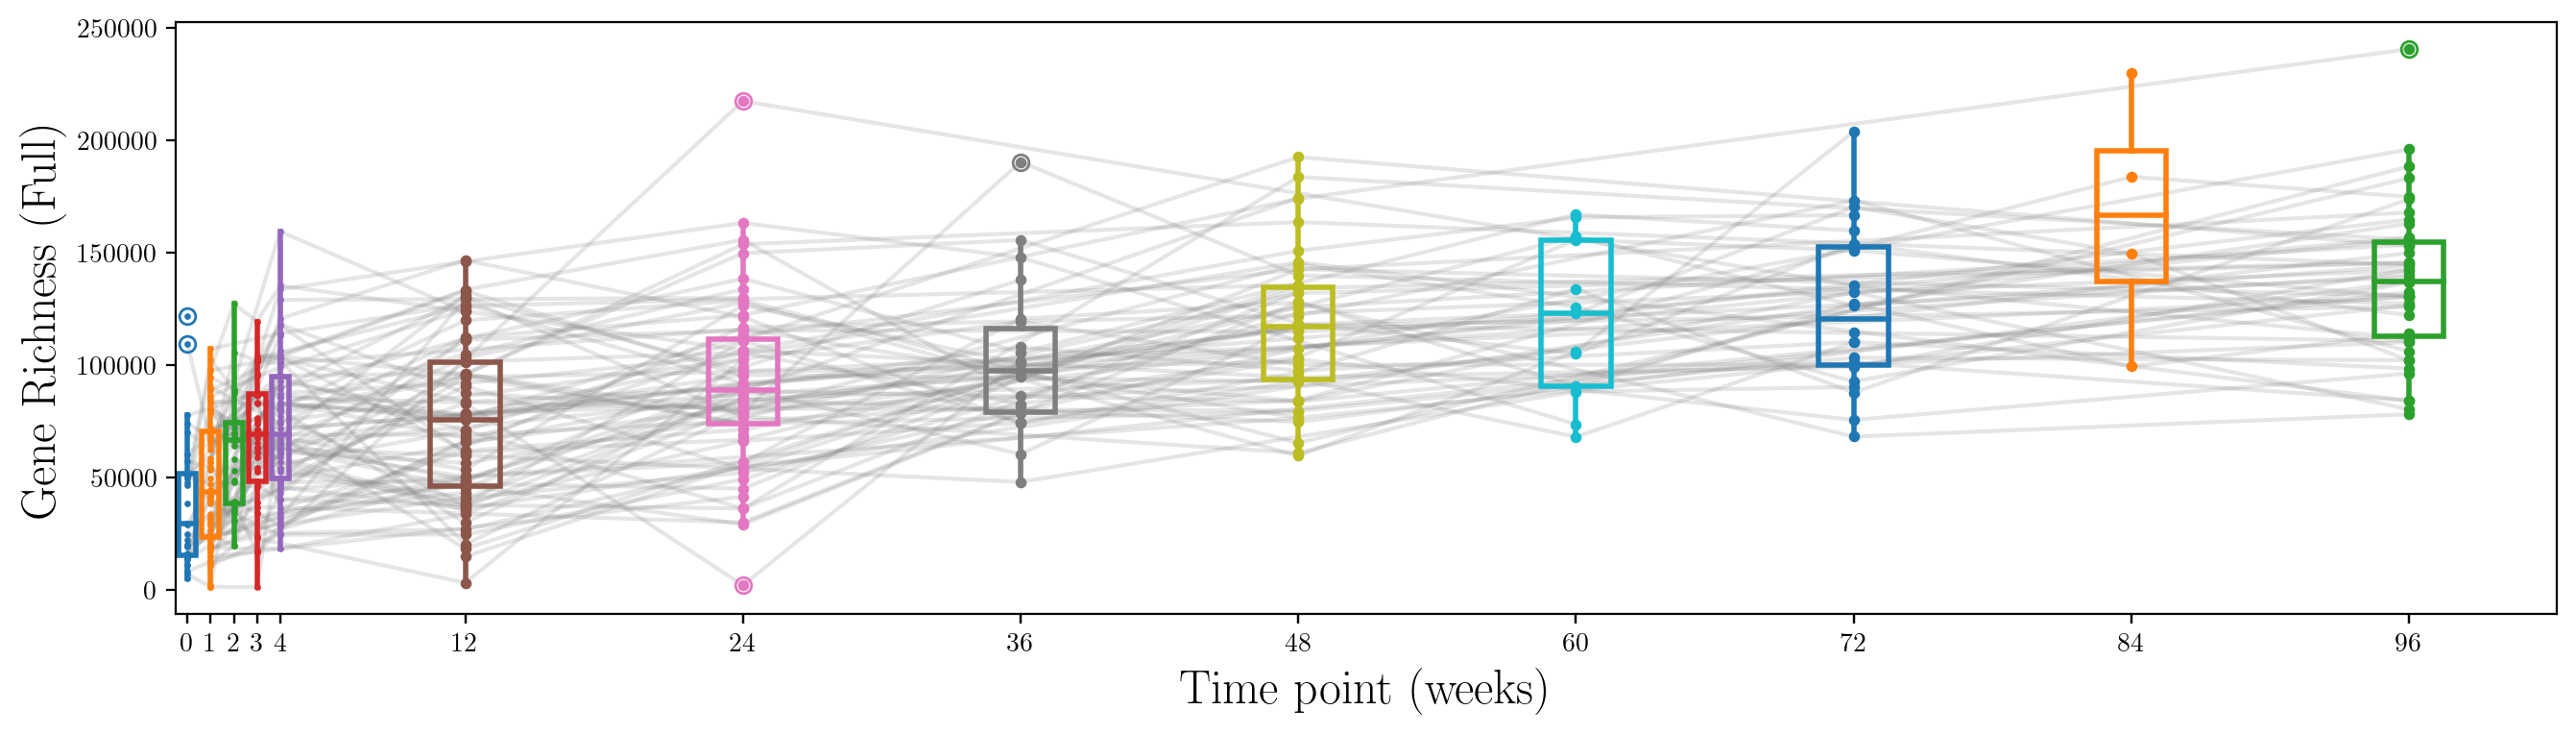

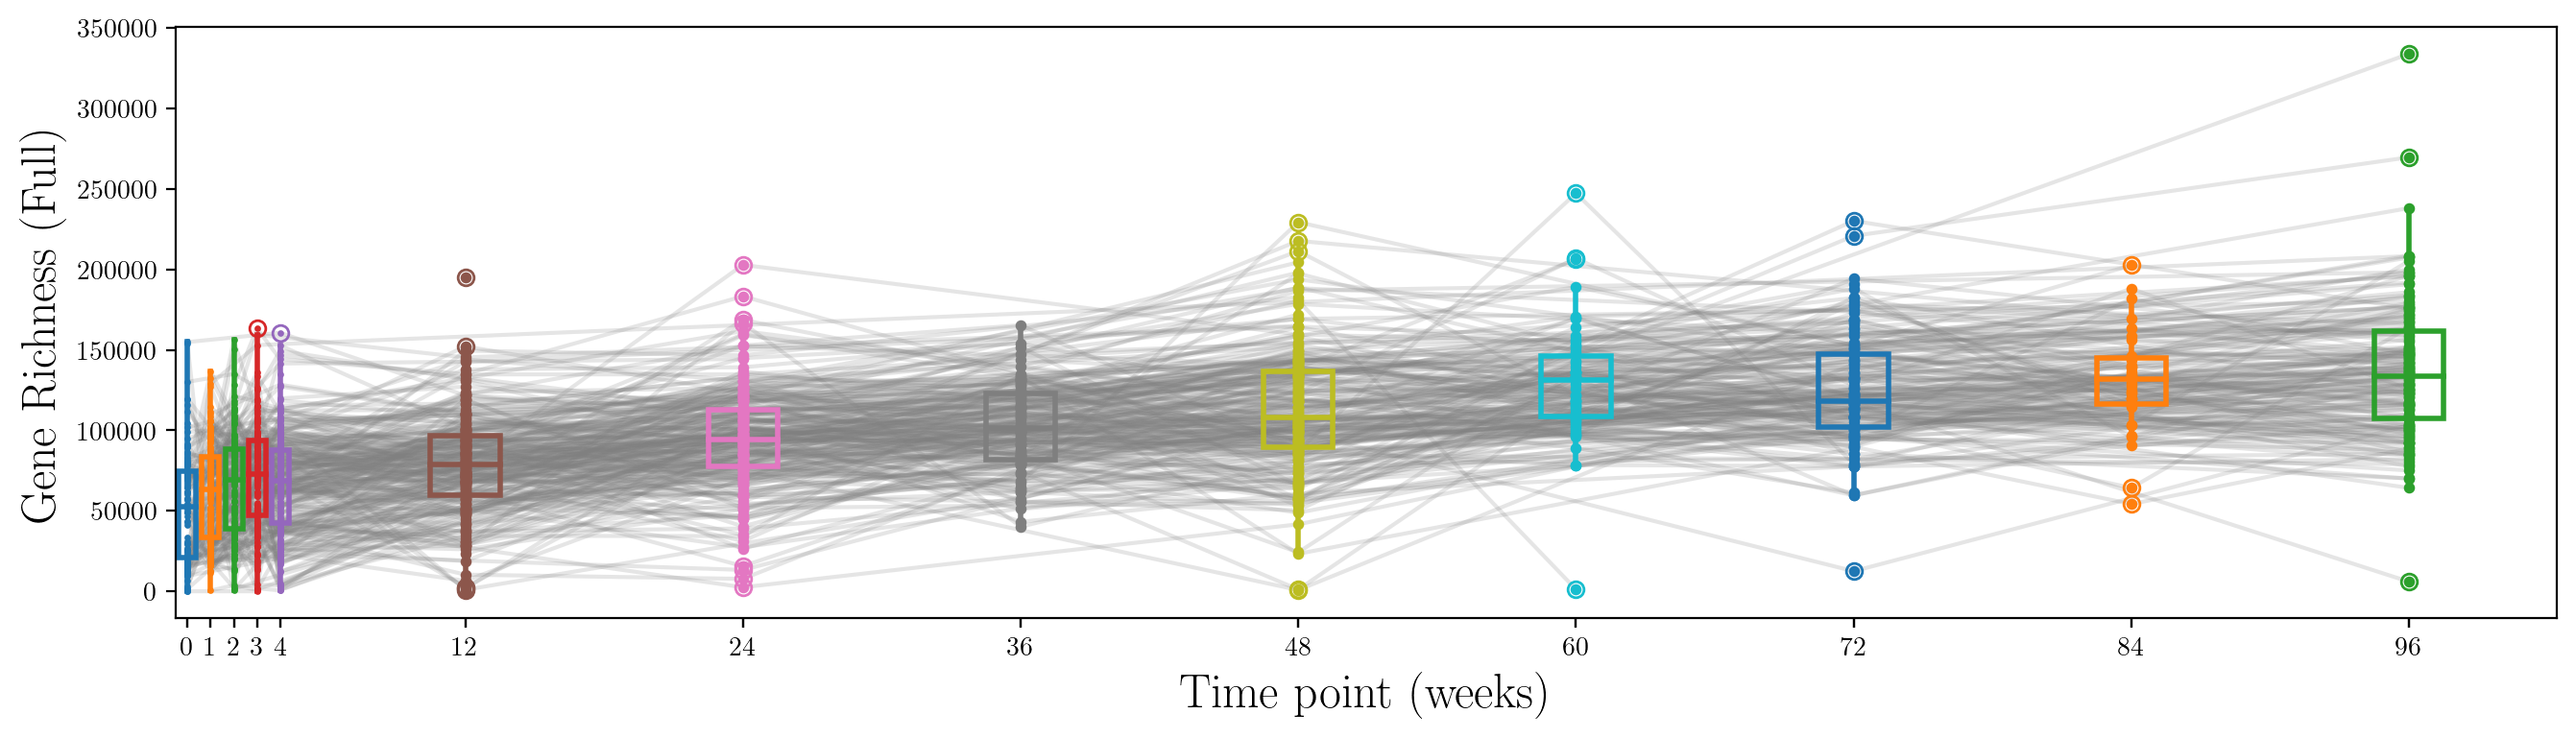

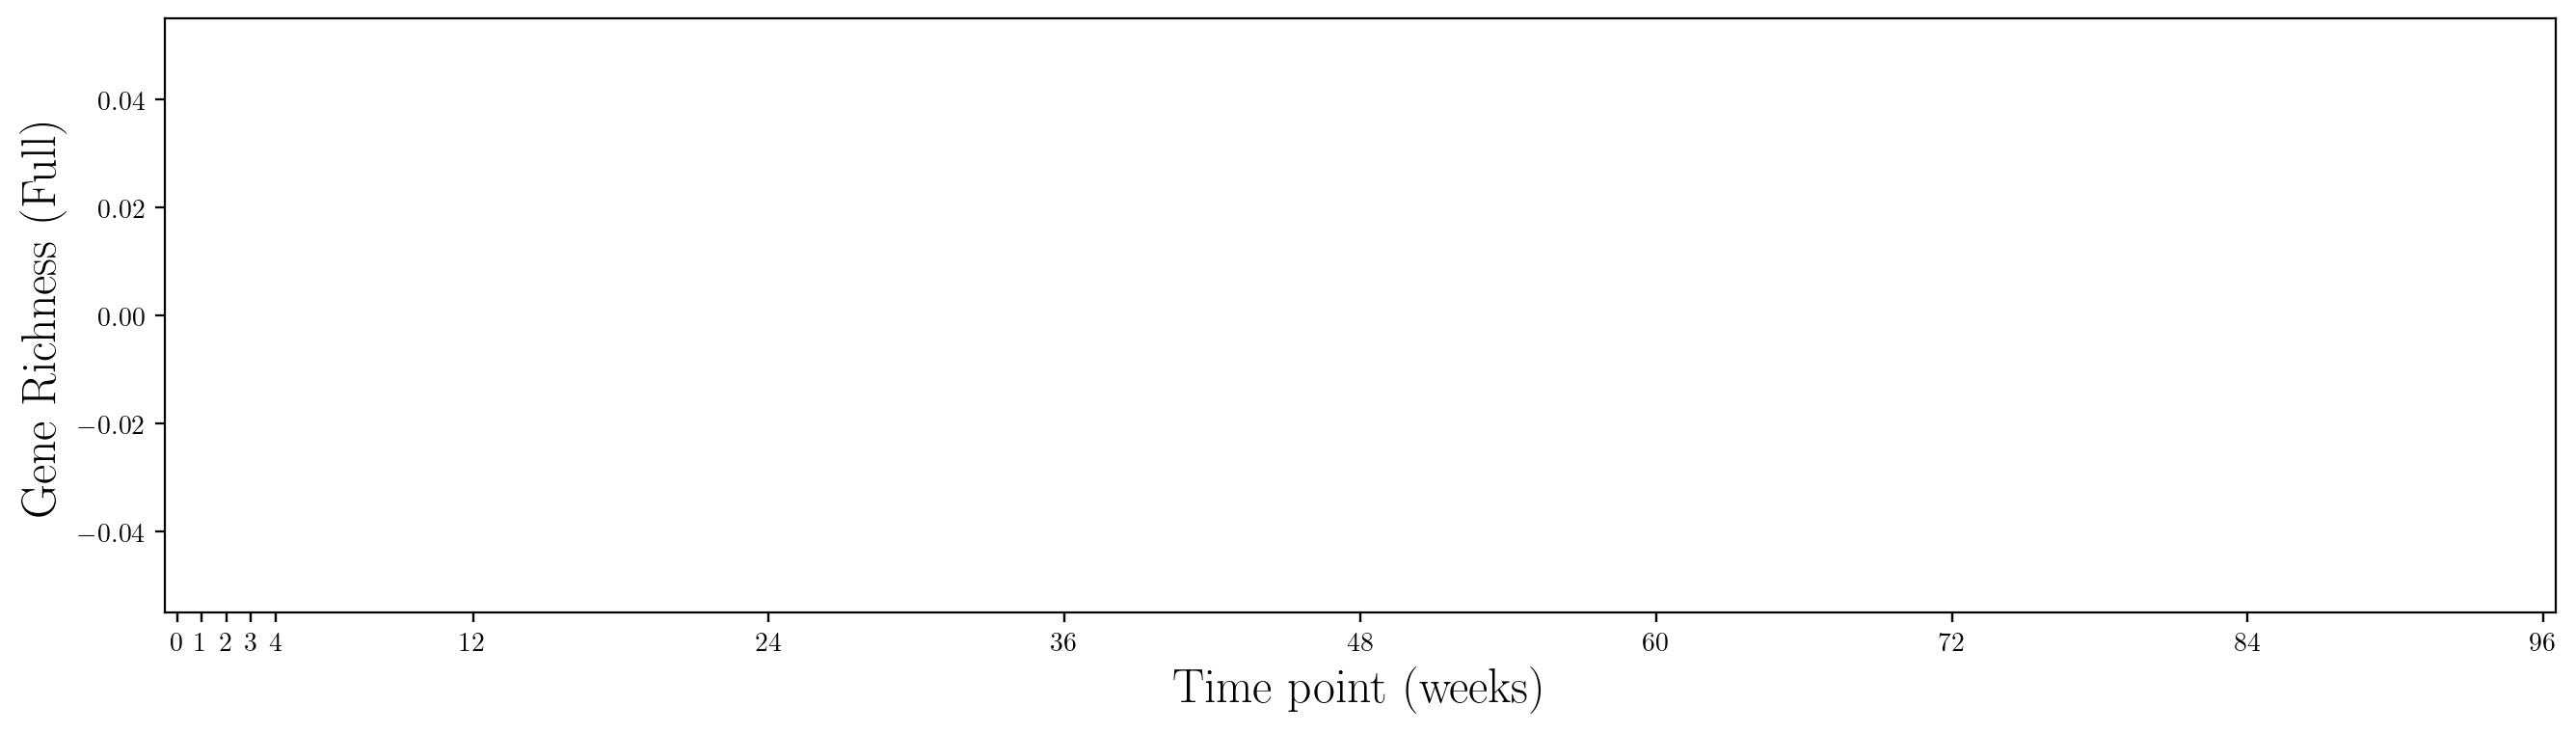

In [16]:
plot_index("Gene Richness (Full)", "gbs_result")